# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Train-Test Split
Week 3 | Lesson 2.3

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain the connection between the bias-variance tradeoff and the train-test split
- Perform a split of data into testing and training sets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl

### The Bias-Variance Tradeoff

We are seeking a model that generalizes. We will build the model using data that we have, but its value comes in predicting outcomes for data we have not yet seen. 

Let's briefly consider the source of possible error in our model:

$$E\left[y_0-\hat f(x_0)\right]^2 = \text{Var}\left(\hat f(x_0)\right) + \left[\text{Bias}\left(\hat f(x_0)\right)\right]^2 + \text{Var}(\epsilon)$$

What do these represent:

- $\text{Var}\left(\hat f(x_0)\right)$ : the variance in your model; the extent to which your model adjusts to perfectly match your data 
- $\left[\text{Bias}\left(\hat f(x_0)\right)\right]^2$ : the bias in your model; the extent to which your model is not capable of matching the data 
- $\text{Var}(\epsilon)$ : the variance in the inherent error

#### THESE ARE ALL POSITIVE

We can only hope to minimize them. We have no control over the variance of the inherent error

## Minimize the Bias 

Minimizing the bias is easy. This is actually what we are doing when we doing a least squares regression (OLS).

![](assets/ols.png)

In fact, according to the Gauss-Markov Theorem, 

> in a linear regression model in which the errors have expectation zero and are uncorrelated and have equal variances, the best linear unbiased estimator (BLUE) of the coefficients is given by the ordinary least squares (OLS) estimator.

https://en.wikipedia.org/wiki/Gauss–Markov_theorem

In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [8]:
xfit = np.linspace(-0.1, 1.0, 12)[:, None]
xfit

array([[-0.1],
       [ 0. ],
       [ 0.1],
       [ 0.2],
       [ 0.3],
       [ 0.4],
       [ 0.5],
       [ 0.6],
       [ 0.7],
       [ 0.8],
       [ 0.9],
       [ 1. ]])

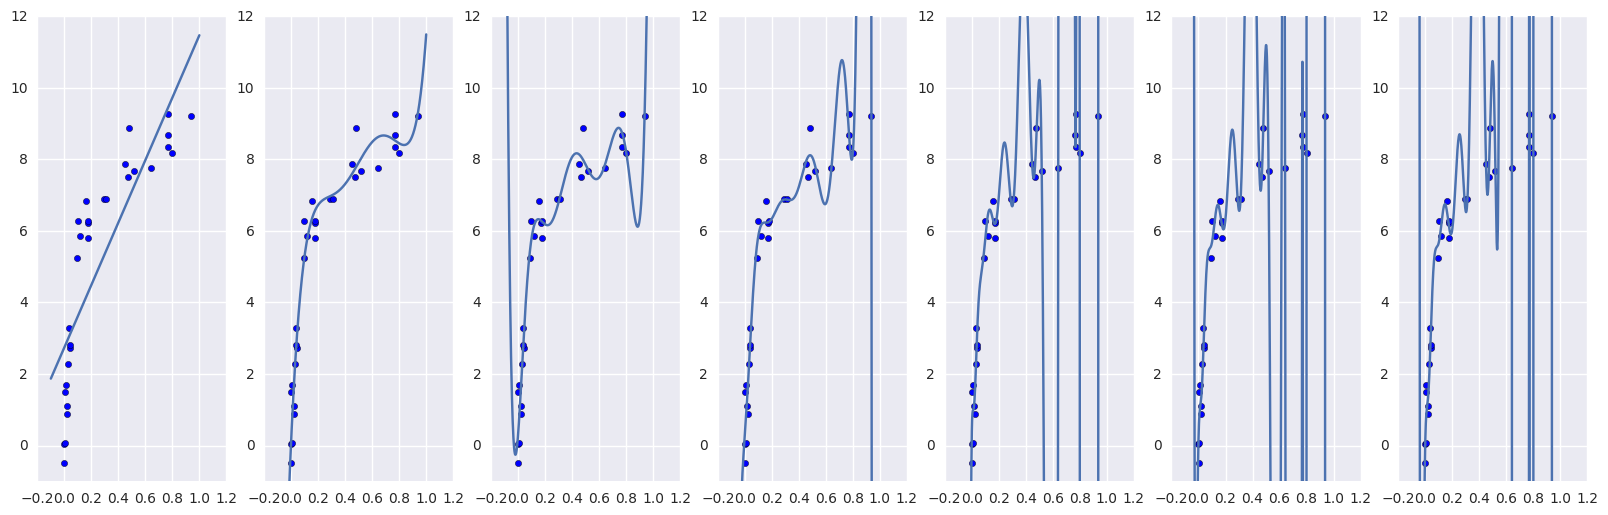

In [12]:
fig = plt.figure(figsize=(20,6))

X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]

models = []
for i in range(7):
    fig.add_subplot(171+i)
    model = PolynomialRegression(4*i+1).fit(X, y)
    models.append(model)
    plt.scatter(X, y)
    plt.plot(xfit, model.predict(xfit))
    plt.ylim(-1, 12)


### Measure the Bias

In [13]:
from sklearn.metrics import mean_absolute_error

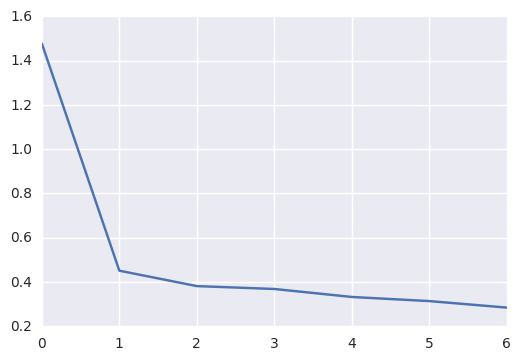

In [14]:
error = [mean_absolute_error(model.predict(X), y) for model in models]
plt.plot(error)

### What if we pass new data?

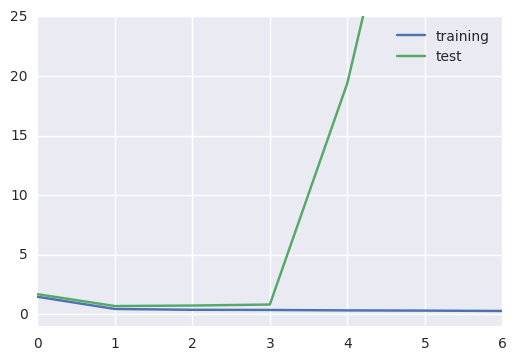

In [16]:
X_new, y_new = make_data(rseed=2)

error_new = [mean_absolute_error(model.predict(X_new), y_new) for model in models]
plt.plot(error, label='training')
plt.plot(error_new, label='test')
plt.ylim(-1,25)
plt.legend()

## Minimize the sum of the Bias and Variance

This is a much more challenging problem. In essence, we seek a model that is simultaneously lacking in complexity (low variance) and able to fit our known data well (low bias). To do this, we split our data into two sets:

- a training set
- a test set

In [17]:
data_file_location = '../../../data/boston.csv'
boston_housing_df = pd.read_csv(data_file_location, 
                                index_col=None,
                                header=None,
                                delim_whitespace=True)

boston_housing_df.columns = ["CRIM", "ZN", "INDUS", "CHAS", 
                             "NOX", "RM", "AGE", "DIS", 
                             "RAD", "TAX", "PTRATIO", "B", 
                             "LSTAT", "MEDV"]

In [18]:
boston_housing_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Best Practices in Developing Predictive Models

1. Clearly state the problem you wish to solve
1. Clearly state the model you will develop to solve the problem
1. Clearly state a metric you will use to assess your performance
1. Clearly define a benchmark against which you will measure the performance of your model using the metric you selected

#### Sort Parameters by their Correlation with `MEDV`

In [25]:
boston_abs_correlations = abs(boston_housing_df.corr()['MEDV'])
boston_abs_correlations.sort_values(inplace=True, ascending=False)
boston_abs_correlations

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

#### Just get the Names

In [27]:
features_names = list(boston_abs_correlations.index)
features_names

['MEDV',
 'LSTAT',
 'RM',
 'PTRATIO',
 'INDUS',
 'TAX',
 'NOX',
 'CRIM',
 'RAD',
 'AGE',
 'ZN',
 'B',
 'DIS',
 'CHAS']

#### Don't need `MEDV`!

In [28]:
features_names.pop(0)
print(features_names)

['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'NOX', 'CRIM', 'RAD', 'AGE', 'ZN', 'B', 'DIS', 'CHAS']


In [29]:
features_names

['LSTAT',
 'RM',
 'PTRATIO',
 'INDUS',
 'TAX',
 'NOX',
 'CRIM',
 'RAD',
 'AGE',
 'ZN',
 'B',
 'DIS',
 'CHAS']

---

## Modeling Median Home Value in Boston

### Problem Statement

We wish to predict Median House Value given a set of 13 features representing known Houses in Boston.

### Solution Statement

We will develop a linear regression model of optimal complexity, capable to taking in a new set of features and returning a predicted median house value. 

### Metric Selection

<img src="assets/regression_metrics.png" width="600px">

In [19]:
from sklearn import metrics

In [20]:
def metric(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

In [21]:
metric((1,1,1),(4,1,1))

1.0

In [22]:
metric((1,1,1),(10,1,1))

3.0

### Benchmark 

---

# the Train-Test Split

The process looks as follows:

1. Split the data into two (not necessarily equally sized) sets, the training set and the test set
1. Set the test set aside
1. Fit the model to the best of our abilities using the training set
1. Evaluate the model separately using both the training set and the test set
   - the evaluation of the model using the training set can be taken to signify bias
   - the evaluation of the model using the test set can be taken to signify variance
1. Repeat steps 3 and 4 until an optimal sum of bias and variance is reached

### Prepare the Data

Pull the target vector off of the dataframe.

Drop the target vector to prepare the feature matrix.

In [30]:
boston_housing_target = boston_housing_df['MEDV']
boston_housing_feature = boston_housing_df.drop('MEDV', axis=1)

### Step 1: Split the data into a Training Set and a Test Set

In [31]:
from sklearn.cross_validation import train_test_split

    >>> a_train, a_test, b_train, b_test = train_test_split(
    ...     a, b, test_size=0.33, random_state=42)

    /Users/chris/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
      "This module will be removed in 0.20.", DeprecationWarning)

In [32]:
feature_matrix_train, \
feature_matrix_test, \
target_vector_train, \
target_vector_test = train_test_split(boston_housing_feature, 
                                      boston_housing_target, 
                                      test_size=0.1,
                                      random_state=11)

### Forward Selection

We will use forward selection to develop our models.

In [33]:
features_names

['LSTAT',
 'RM',
 'PTRATIO',
 'INDUS',
 'TAX',
 'NOX',
 'CRIM',
 'RAD',
 'AGE',
 'ZN',
 'B',
 'DIS',
 'CHAS']

In [34]:
from sklearn.linear_model import LinearRegression

#### Let's store the errors

In [35]:
errors_training_set = []
errors_test_set = []

### Step 2: Fit the Model

Here we fit a linear model using a single feature, `LSTAT`.

#### Prepare the data for fitting

In [39]:
print(features_names[:1])
ftr_mtx_01_p_trn = pd.DataFrame(feature_matrix_train[features_names[:1]])
ftr_mtx_01_p_tst = pd.DataFrame(feature_matrix_test[features_names[:1]])

['LSTAT']


In [41]:
ftr_mtx_01_p_trn.shape, ftr_mtx_01_p_tst.shape

((455, 1), (51, 1))

#### Build Model with One Feature

In [42]:
LINEAR_REGRESSOR = LinearRegression()
LINEAR_REGRESSOR.fit(ftr_mtx_01_p_trn, target_vector_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Step 3: Evaluate the Model

In [43]:
predict_train = LINEAR_REGRESSOR.predict(ftr_mtx_01_p_trn)
predict_test = LINEAR_REGRESSOR.predict(ftr_mtx_01_p_tst)
error_training_set = metric(predict_train, target_vector_train)
error_test_set = metric(predict_test, target_vector_test)
errors_training_set.append(error_training_set)
errors_test_set.append(error_test_set)
error_training_set, error_test_set

(4.590757393165747, 4.0318532631398574)

### Step 2: Fit the Model

Here we fit a linear model using two features, `LSTAT` and `RM`.

#### Prepare the data for fitting

In [44]:
print(features_names[:2])
ftr_mtx_02_p_trn = pd.DataFrame(feature_matrix_train[features_names[:2]])
ftr_mtx_02_p_tst = pd.DataFrame(feature_matrix_test[features_names[:2]])

['LSTAT', 'RM']


#### Build Model with Two Features

In [45]:
LINEAR_REGRESSOR = LinearRegression()
LINEAR_REGRESSOR.fit(ftr_mtx_02_p_trn, target_vector_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Step 3: Evaluate the Model

In [46]:
predict_train = LINEAR_REGRESSOR.predict(ftr_mtx_02_p_trn)
predict_test = LINEAR_REGRESSOR.predict(ftr_mtx_02_p_tst)
error_training_set = metric(predict_train, target_vector_train)
error_test_set = metric(predict_test, target_vector_test)
errors_training_set.append(error_training_set)
errors_test_set.append(error_test_set)
error_training_set, error_test_set

(3.9916630615888615, 3.8862940636044545)

### Step 2: Fit the Model

Here we fit a linear model using three features, `LSTAT`, `RM`, and `PTRATIO`.

#### Prepare the data for fitting

In [47]:
print(features_names[:3])
ftr_mtx_03_p_trn = pd.DataFrame(feature_matrix_train[features_names[:3]])
ftr_mtx_03_p_tst = pd.DataFrame(feature_matrix_test[features_names[:3]])

['LSTAT', 'RM', 'PTRATIO']


#### Build Model with Three Features

In [48]:
LINEAR_REGRESSOR = LinearRegression()
LINEAR_REGRESSOR.fit(ftr_mtx_03_p_trn, target_vector_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Step 3: Evaluate the Model

In [49]:
predict_train = LINEAR_REGRESSOR.predict(ftr_mtx_03_p_trn)
predict_test = LINEAR_REGRESSOR.predict(ftr_mtx_03_p_tst)
error_training_set = metric(predict_train, target_vector_train)
error_test_set = metric(predict_test, target_vector_test)
errors_training_set.append(error_training_set)
errors_test_set.append(error_test_set)
error_training_set, error_test_set

(3.7117696217095824, 3.2892304671860551)

## Let Python Do The Work

In [50]:
training_feature_matrics = [
    pd.DataFrame(feature_matrix_train[features_names[:4]]),
    pd.DataFrame(feature_matrix_train[features_names[:5]]),
    pd.DataFrame(feature_matrix_train[features_names[:6]]),
    pd.DataFrame(feature_matrix_train[features_names[:7]]),
    pd.DataFrame(feature_matrix_train[features_names[:8]]),
    pd.DataFrame(feature_matrix_train[features_names[:9]])
]

test_feature_matrics = [
    pd.DataFrame(feature_matrix_test[features_names[:4]]),
    pd.DataFrame(feature_matrix_test[features_names[:5]]),
    pd.DataFrame(feature_matrix_test[features_names[:6]]),
    pd.DataFrame(feature_matrix_test[features_names[:7]]),
    pd.DataFrame(feature_matrix_test[features_names[:8]]),
    pd.DataFrame(feature_matrix_test[features_names[:9]])
]

In [51]:
for training_matrix, test_matrix in zip(
    training_feature_matrics,
    test_feature_matrics):
    
    LINEAR_REGRESSOR = LinearRegression()
    LINEAR_REGRESSOR.fit(training_matrix, target_vector_train)
    predict_train = LINEAR_REGRESSOR.predict(training_matrix)
    predict_test = LINEAR_REGRESSOR.predict(test_matrix)
    error_training_set = metric(predict_train, target_vector_train)
    error_test_set = metric(predict_test, target_vector_test)
    errors_training_set.append(error_training_set)
    errors_test_set.append(error_test_set)

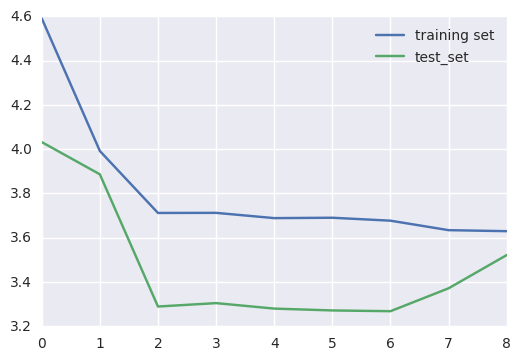

In [52]:
plt.plot(errors_training_set, label='training set')
plt.plot(errors_test_set, label='test_set')
plt.legend()